In [1]:
import math
import os
import os.path as osp
import sys
print(sys.executable)
import time

import matplotlib.pylab as plt
import numpy as np
import open3d as o3d
import seaborn as sns
import torch
from pytorch3d.ops import knn_points

/home/rilab/.pyenv/versions/3.10.11/envs/rilab/bin/python
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
colors = sns.color_palette("husl", 6)

def squared_distance(x1, x2):
    """
    Computes squared distance matrix between two arrays of row vectors.

    Code originally from:
        https://github.com/pytorch/pytorch/issues/15253#issuecomment-491467128
    """
    
    x1_norm = x1.pow(2).sum(dim=-1, keepdim=True)
    x2_norm = x2.pow(2).sum(dim=-1, keepdim=True)
 
    
      
    res = torch.addmm(x2_norm.transpose(-2, -1), x1, x2.transpose(-2, -1), alpha=-2).add_(x1_norm)
    return res
   
    
def get_kernel(x, y, lengthscale=1.0):
    pairwise_dists = squared_distance(x/lengthscale, y/lengthscale)
    h_sq = 0.5 * torch.median(pairwise_dists) / math.log(x.shape[0])
    return torch.exp(-0.5*pairwise_dists/h_sq)

    
def phi( X,score_func):
    """
    
    Code originally from:
        https://colab.research.google.com/github/activatedgeek/stein-gradient/blob/master/Stein.ipynb#scrollTo=2fPfeNqDrYgo
    """
    X = X.detach().requires_grad_(True)
    K_XX = get_kernel(X, X.detach())
    grad_K = -torch.autograd.grad(K_XX.sum(), X)[0]
    phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)

    return phi


def plot_kde(x, y, z, roll, pitch, yaw, bwd, do_shading, max_dist):
    def plot_one_dimension(data, label, color):
        sns.kdeplot(
            data.squeeze().cpu().detach().numpy(),
            label=label,
            color=color,
            bw_adjust=bwd,
        )
        
    _, ax = plt.subplots(1)
    plot_one_dimension(x, "X", colors[0])
    plot_one_dimension(y, "Y", colors[1])
    plot_one_dimension(z, "Z", colors[2])
    plot_one_dimension(roll, "Roll", colors[3])
    plot_one_dimension(pitch, "Pitch", colors[4])
    plot_one_dimension(yaw, "Yaw", colors[5])
    ax.legend()

    
def plot_samples(x, y, z, roll, pitch, yaw):
    def plot_one_dimension(data, label, color):
        plt.plot(
            data.squeeze().cpu().detach().numpy(),
            label=label,
            color=color,
            linestyle="none",
            marker="o"
        )
        
    _, ax = plt.subplots(1)
    plot_one_dimension(x, "X", colors[0])
    plot_one_dimension(y, "Y", colors[1])
    plot_one_dimension(z, "Z", colors[2])
    plot_one_dimension(roll, "Roll", colors[3])
    plot_one_dimension(pitch, "Pitch", colors[4])
    plot_one_dimension(yaw, "Yaw", colors[5])
    plt.xlabel("Particle #")
    plt.ylabel("Parameter Value")
    ax.legend()
    

def load_pcd(s_arr, t_arr, dtype, device):
    """Loads the provided source and target clouds."""
    # pcd_s = o3d.io.read_point_cloud(path_source)
    # pcd_t = o3d.io.read_point_cloud(path_target)

    # s_arr = np.asarray(pcd_s.points)
    # t_arr = np.asarray(pcd_t.points)
    # print(s_arr.shape)
    # print(s_arr)

    s_tor = torch.from_numpy(s_arr).type(dtype).to(device)
    t_tor = torch.from_numpy(t_arr).type(dtype).to(device)
    
    return s_tor, t_tor

    
def normalize_clouds(source_torch, target_torch):
    """Normalizes the cloud coordinates to lie withing [0, 1]."""
    max_s = torch.max(torch.abs(source_torch))
    
    max_t = torch.max(torch.abs(target_torch))
    
    abs_max = torch.max(max_s, max_t)
    source_torch = source_torch / abs_max
    target_torch = target_torch / abs_max
    
    return source_torch, target_torch, abs_max


def initialize_particles(particle_count, device, from_, to_):
    b = 1
    x =  (from_[0] - to_[0]) * torch.rand(particle_count, b, device=device) + to_[0]
    y =  (from_[1] - to_[1]) * torch.rand(particle_count, b, device=device) + to_[1]
    z =  (from_[2] - to_[2]) * torch.rand(particle_count, b, device=device) + to_[2] 
    r =  (from_[3] - to_[3]) * torch.rand(particle_count, b, device=device) + to_[3]
    p =  (from_[4] - to_[4]) * torch.rand(particle_count, b, device=device) + to_[4] 
    ya = (from_[5] - to_[5]) * torch.rand(particle_count, b, device=device) + to_[5]

    return x, y, z, r, p, ya    


def get_stein_pairs(
    source,             # particle_count x batchsize x 3
    transformed_source, # particle_count x batchsize x 3
    target,             # particle_count x batchsize x 3
    max_dist            # threshold distance to reject matching pair
):
    
    matches =  knn_points(transformed_source, target, None, None, K=1,return_nn=True)
    # Get the target cloud at the paired indices
    target_paired = matches.knn[:, :, 0, :]
    
    source=ignore_far_away_matches(source,matches.dists.squeeze() ,max_dist)
    transformed_source=ignore_far_away_matches(transformed_source,matches.dists.squeeze() ,max_dist)
    target_paired=ignore_far_away_matches(target_paired,matches.dists.squeeze() ,max_dist)
    
    return (source, transformed_source, target_paired)
    


#@torch.jit.script
def ignore_far_away_matches(cloud,dist_norm,max_dist):
    cloud[dist_norm > max_dist]=0
    return cloud


In [3]:
#%%heat
class SteinSGDICP:
    
    def __init__(
        self,
        source_cloud,
        target_cloud,
        x, y, z, r, p, ya,
        normalize_clouds=True,
        iterations=150,
        batch_size=150,
        max_dist=1,
        optimizer_class="Adam",
        lr=0.01
    ):  
        self.particle_size = x.shape[0]
        
        self.x = x.view(self.particle_size,1,1)
        self.y = y.view(self.particle_size,1,1)
        self.z = z.view(self.particle_size,1,1)
        self.r = r.view(self.particle_size,1,1)
        self.p = p.view(self.particle_size,1,1)
        self.ya = ya.view(self.particle_size,1,1)
     
        self.device = target_cloud.device
        
        self.iter = iterations
        self.batch_size = batch_size
        
        self.max_dist = max_dist
        
        self.optimizer_class = optimizer_class
        self.lr = lr
        
        self.source_cloud = source_cloud
        self.target_cloud = target_cloud
        self.normalize_clouds = normalize_clouds

    def vectorized_rotation(self):
        #r, p and ya are particle sizx1x1 column tensors where n is the number of particles
        #output is particle sizex3x3
        
        T=torch.stack(
            [torch.stack(
                [ torch.cos(self.p)*torch.cos(self.ya), 
                 (torch.sin(self.r)*torch.sin(self.p)*torch.cos(self.ya)- torch.cos(self.r)*torch.sin(self.ya)), 
                 (torch.sin(self.r)*torch.sin(self.ya) + torch.cos(self.r)*torch.sin(self.p)*torch.cos(self.ya))
                ],dim=3).squeeze(1),
            torch.stack(
                [torch.cos(self.p)*torch.sin(self.ya), 
                 (torch.cos(self.r)*torch.cos(self.ya) + torch.sin(self.r)*torch.sin(self.p)*torch.sin(self.ya)),
                 (torch.cos(self.r)*torch.sin(self.p)*torch.sin(self.ya) -torch.sin(self.r)*torch.cos(self.ya))
                ],dim=3).squeeze(1),
            torch.stack(
                [-torch.sin(self.p), 
                 torch.sin(self.r)*torch.cos(self.p), 
                 torch.cos(self.r)*torch.cos(self.p)
                ],dim=3).squeeze(1)],
            dim=2).squeeze()
        
        return T

    def vectorized_trans(self):
        """Returns a tensor containing the translation parameters.
        
        Returns:
            Returns a Nx3 tensor containing the translation parameters
        """
        return torch.cat([self.x, self.y, self.z], dim=1)

    def partial_derivatives_stein(self):
        A = torch.cos(self.ya) 
        B = torch.sin(self.ya) 
        C = torch.cos(self.p) 
        D = torch.sin(self.p) 
        E = torch.cos(self.r) 
        F = torch.sin(self.r) 

        DE = D * E 
        DF = D * F 
        AC = A * C 
        AF = A * F 
        AE = A * E 
        ADE = A * DE 

        ADF = A * DF 
        BC = B * C 
        BE = B * E 
        BF = B * F 
        BDE = B * DE 

        torch_0 = torch.zeros(self.particle_size, 1, 1, device=self.device)
        partial_roll = torch.stack([
            torch.stack([torch_0,    ADE + BF,   BE - ADF],     dim=3).squeeze(1),
            torch.stack([torch_0,   -AF + BDE,   B * -DF - AE], dim=3).squeeze(1),
            torch.stack([torch_0,    C * E   ,   C * -F],       dim=3).squeeze(1)
        ], dim=2).squeeze()

        partial_pitch = torch.stack([
                    torch.stack([A * -D, AC * F ,  AC * E], dim=3).squeeze(1),
                    torch.stack([B * -D, BC * F , BC * E ], dim=3).squeeze(1),
                    torch.stack([-C    , -DF    , -DE]    , dim=3).squeeze(1)
        ], dim=2).squeeze()

        partial_yaw = torch.stack([
                    torch.stack([-BC,     -B * DF - AE ,  AF - BDE ], dim=3).squeeze(1),
                    torch.stack([AC,      -BE + ADF    ,  ADE + BF ], dim=3).squeeze(1),
                    torch.stack([torch_0,  torch_0    , torch_0    ], dim=3).squeeze(1)
        ], dim=2).squeeze()

        return partial_roll, partial_pitch, partial_yaw

    def stein_grads(
        self,
        source_resized,   #each cloud here is particle_size x batchsize x 3
        transformed_paired,
        target_paired,
        scaling_factor  # scaling with point size as required by stein formulation. 
    ):
        # Get the number of dummy points (zero points inserted during filtering) to get
        # mean by excluding their counts
        zero_points_size = (transformed_paired.sum(dim=2)==0).sum(dim=1)
        partial_derivatives = self.partial_derivatives_stein() 

        error = transformed_paired - target_paired

        input_ = torch.empty(self.particle_size, 6, device=self.device) # particle_count  x 6
        gradient_cost = torch.zeros_like(input_)

        # For xyz gradients, get sum of error in xyz dim independently for each particle
        # sumerr = error.sum(dim=1)
        
        # Zero matching will make grad to nan since currently we are not monitoring low
        # matching pairs. So set it to 1 if we have number of zero=batch size (i.e. non matching pair)
        a = torch.zeros_like(zero_points_size)
        # set a to 1 where dummy points == batch size
        a[(torch.where (zero_points_size==self.batch_size))] = 1

        gradient_cost[:,0:3] = error.sum(dim=1)/((self.batch_size-zero_points_size.view(self.particle_size,1))+a.view(self.particle_size,1))#divide by no. of points after excluding dummy points
        gradient_cost[:,3] = torch.einsum('pbc,pbc->pb',[error,(torch.einsum('prc,pbc->pbr', [(partial_derivatives)[0],source_resized]))]).sum(dim=1)/((self.batch_size-zero_points_size)+a)#.view(self.particle_size,1).squeeze())
        gradient_cost[:,4] = torch.einsum('pbc,pbc->pb',[error,(torch.einsum('prc,pbc->pbr', [(partial_derivatives)[1],source_resized]))]).sum(dim=1)/((self.batch_size-zero_points_size)+a)#.view(self.particle_size,1).squeeze())
        gradient_cost[:,5] = torch.einsum('pbc,pbc->pb',[error,(torch.einsum('prc,pbc->pbr', [(partial_derivatives)[2],source_resized]))]).sum(dim=1)/((self.batch_size-zero_points_size)+a)#.view(self.particle_size,1).squeeze())
        
        return gradient_cost*scaling_factor
   
    def stein_align(self):
        abs_max=1
        s_tor = self.source_cloud
        t_tor = self.target_cloud
        gradient_scaling_factor = s_tor.shape[0]
        
        if self.normalize_clouds:
            s_tor, t_tor, abs_max = normalize_clouds(self.source_cloud, self.target_cloud)
            self.x = self.x / abs_max
            self.y = self.y / abs_max
            self.z = self.z / abs_max
            # If we normalize cloud, we need to scale gradients with normalizing factor to be stable
            gradient_scaling_factor = abs_max * s_tor.shape[0]
            
        
        def batch_generator():
            while True:
                indexes = np.random.randint(0, len(s_tor), self.batch_size)
                yield s_tor[indexes]
        mini_batch_sampler = batch_generator()
     
        parameters = [self.x, self.y, self.z, self.r, self.p, self.ya]
        optimizer = None
        print("Optimizing using: ", end="")
        if self.optimizer_class == "Adam":
            print("Adam")
            optimizer = torch.optim.Adam(parameters, lr=self.lr)
        elif self.optimizer_class == "RMSprop":
            print("Prop")
            optimizer = torch.optim.RMSprop(
                parameters,
                lr=self.lr,
                weight_decay=1e-8,
                momentum=0.9
            )
        elif self.optimizer_class == "SGD":
            print("SGD")
            optimizer = torch.optim.SGD(parameters, lr=self.lr)
        elif self.optimizer_class == "Adagrad":
            print("Adagrad")
            optimizer = torch.optim.Adagrad(parameters, lr=self.lr)
        else:
            raise NotImplementedError

        max_dist = self.max_dist / abs_max

        t_start = time.time()
        
        for epoch in range(self.iter):
            # Get a minibatch 
          
            minibatch1 = next(mini_batch_sampler)
            
            minibatch = minibatch1.expand(self.particle_size, self.batch_size, 3).clone()

            trans_mat = self.vectorized_trans()
            rot_mat = self.vectorized_rotation()

            s_transformed = torch.einsum(
                "pmc,prc->pmr",
                [minibatch,rot_mat]
            ) + trans_mat.view(self.particle_size, 1, 3)
            
            
            source_resized, transformed_paired, target_paired = get_stein_pairs(
                    minibatch,
                    s_transformed,
                    t_tor.expand(self.particle_size, t_tor.shape[0], 3).clone(),
                    max_dist
                   
                )


            mean_grads = self.stein_grads(
                source_resized,
                transformed_paired,
                target_paired,
                gradient_scaling_factor
            )

            stein_v_grads = phi(
                torch.stack([self.x,self.y,self.z,self.r,self.p,self.ya]).squeeze().T,
                -mean_grads
            )
            #
            self.x.grad = -stein_v_grads[:,0].view(self.particle_size, 1, 1).clone()
            self.y.grad = -stein_v_grads[:,1].view(self.particle_size, 1, 1).clone()
            self.z.grad = -stein_v_grads[:,2].view(self.particle_size, 1, 1).clone()

            self.r.grad = -stein_v_grads[:,3].view(self.particle_size, 1, 1).clone()
            self.p.grad = -stein_v_grads[:,4].view(self.particle_size, 1, 1).clone()
            self.ya.grad = -stein_v_grads[:,5].view(self.particle_size, 1, 1).clone()

            optimizer.step()
            optimizer.zero_grad()

        t_end = time.time()
        
        particle_pose = torch.stack([
            self.x*abs_max,
            self.y*abs_max,
            self.z*abs_max,
            self.r,
            self.p,
            self.ya
        ]).squeeze().T
        
        print("Stein ICP computation: {:.2f}s".format(t_end - t_start))
        return particle_pose

In [9]:

import torch
particle_count = 100
max_dist = 2.8
# path_source = "source.pcd"
# path_target = "target.pcd"
src = np.load("./data/pcd_0001.npy")
trgt = np.load("./data/pcd_0040.npy")

# pass through filter
src_filtered = src[np.where(src[:,2]>0.5)]
trgt_filtered = trgt[np.where(trgt[:,2]>0.5)]

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor


#uniform initialization
from_ = torch.tensor([-0.8, -0.5, -0.1, -0.1753/4, -0.1753/4, -0.1753]).to(device)
to_ = torch.tensor([0.8, 0.5, 0.1, 0.1753/4, 0.1753/4, 0.1753]).to(device)

s_tor, t_tor = load_pcd(src_filtered, trgt_filtered, dtype, device)
pose_guess=initialize_particles(particle_count, device, from_, to_)

stein = SteinSGDICP(
    s_tor,
    t_tor,
    pose_guess[0], pose_guess[1], pose_guess[2], pose_guess[3], pose_guess[4], pose_guess[5],
    max_dist=max_dist,
    optimizer_class="Adam",
    iterations=50,
    lr=0.01,
    batch_size=50
)

particle_poses = stein.stein_align()


Optimizing using: Adam
Stein ICP computation: 10.16s


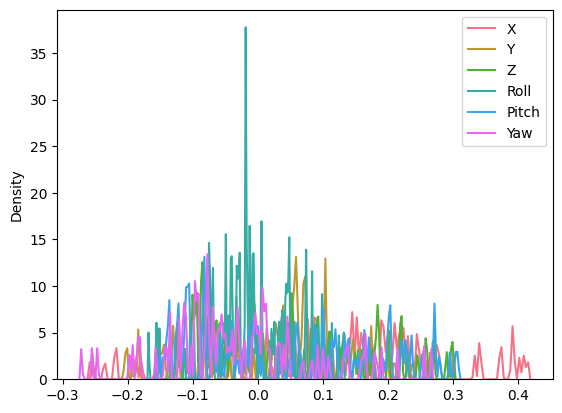

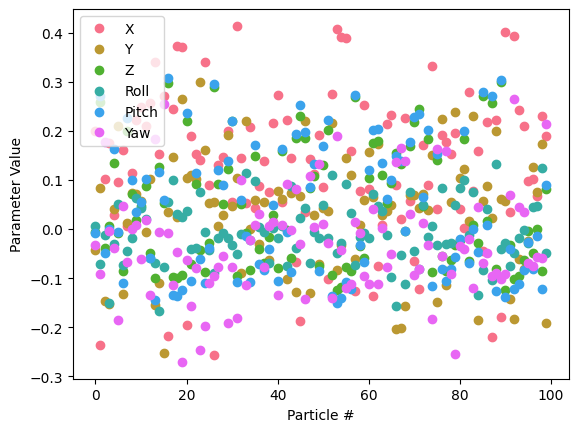

In [10]:
plot_kde(
    particle_poses[:, 0],
    particle_poses[:, 1],
    particle_poses[:, 2],
    particle_poses[:, 3],
    particle_poses[:, 4],
    particle_poses[:, 5],
    0.0254,
    True,
    max_dist
)

plot_samples(
    particle_poses[:, 0],
    particle_poses[:, 1],
    particle_poses[:, 2],
    particle_poses[:, 3],
    particle_poses[:, 4],
    particle_poses[:, 5]
)

In [11]:
# visualize pcd
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(s_tor.cpu().numpy())
pcd.paint_uniform_color([1, 0.706, 0])

pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(t_tor.cpu().numpy())
pcd2.paint_uniform_color([0, 0.651, 0.929])

o3d.visualization.draw_geometries([pcd, pcd2])


In [12]:
import pyvista as pv
point_cloud = pv.PolyData(s_tor.cpu().numpy())
point_cloud['height'] = point_cloud.points[:,2]
# point_cloud.plot(window_size=[500,500],jupyter_backend='panel',
#                  cmap='jet',point_size=4,background='w',border=True)

point_cloud_trgt = pv.PolyData(t_tor.cpu().numpy())
point_cloud_trgt['height'] = point_cloud_trgt.points[:,2]
# point_cloud_trgt.plot(window_size=[500,500],jupyter_backend='panel',
#                     cmap='jet',point_size=4,background='w',border=True)

# Plot both meshes all at once with different colors
p = pv.Plotter()
p.add_mesh(point_cloud, cmap='Blues', point_size=4)
p.add_mesh(point_cloud_trgt, cmap='Reds', point_size=4)
p.show_grid()
p.show()

Widget(value="<iframe src='http://localhost:35117/index.html?ui=P_0x7f1f2d747940_2&reconnect=auto' style='widt…

In [7]:
import pyvista as pv
import numpy as np

# visualize pcd
pcd = pv.PolyData(s_tor.cpu().numpy())
pcd2 = pv.PolyData(t_tor.cpu().numpy())
# pcd3 = pv.PolyData(particle_poses.cpu().numpy())
pcd3 = pv.PolyData(particle_poses[:,0:3].cpu().numpy())

# Add a mesh model to the plotter
plotter = pv.Plotter()
plotter.add_mesh(pcd, color='red', point_size=5)
plotter.add_mesh(pcd2, color='blue', point_size=5)
plotter.add_mesh(pcd3, color='green', point_size=5)

# Render the window
plotter.show()



Widget(value="<iframe src='http://localhost:37571/index.html?ui=P_0x7fea3c44f040_0&reconnect=auto' style='widt…

In [28]:
particle_poses.cpu().numpy().shape

(100, 6)

In [25]:
t_tor.shape

torch.Size([90001, 3])